In [1]:
!pip install transformers
!pip install sentencepiece
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 74.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=f21650c9e75b50050bd7bf4070c1b282c8d812791f07d5985c64cbbfdfb16b1c
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Success

In [16]:
import torch
import torch.nn as nn
import json
import random
import pandas as pd
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import time
import datetime
import re
import numpy as np
import emoji
from transformers import *
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from sklearn.metrics import accuracy_score,f1_score
from sklearn.utils.class_weight import compute_class_weight
# from transformers import BertForSequenceClassification, AdamW, BertConfig
from keras_preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, DataLoader
from sklearn.metrics import *
from sklearn.utils import *
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [ ]:
def Diff(a,b):
    return list(set(a) -set(b))

def re_sub(pattern, repl,text):
    return re.sub(pattern, repl, text)


def preprocess_sent(sent):
    sent = re.sub(r"http\S+", " ", sent.lower())
    sent = re.sub(r"@\S+", "@user", sent)

    #print(sent)
    sent = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "",sent)
    sent = emoji.demojize(sent)
    sent = re_sub(r"[:\*]", " ",sent)
    sent = re.sub(r"[<\*>]", " ",sent)
    sent = sent.replace("&amp;", " ")
    sent = sent.replace("ðŸ¤§", " ")
    sent = sent.replace("\n", " ")
    sent = sent.replace("ðŸ˜¡", " ")
    return sent

def evalMetric(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    mf1Score = f1_score(y_true, y_pred, average='macro')
    f1Score  = f1_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    area_under_c = auc(fpr, tpr)
    recallScore = recall_score(y_true, y_pred)
    precisionScore = precision_score(y_true, y_pred)
    return {"accuracy": accuracy, 'mF1Score': mf1Score, 'f1Score': f1Score, 'auc': area_under_c, 
            'precision': precisionScore, 'recall': recallScore}
#Creating an attention mask - For actual tokens its set to 1, for padding tokens its set to 0
def create_attention_masks(input_ids):
    attention_masks = []
    for seq in tqdm(input_ids):
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return np.array(attention_masks)
#tokenizes the data
def getFeaturesandLabel(X,y):
    sentences = list(X)
    sentences = ["[CLS] "+ preprocess_sent(i) + " [SEP]"for i in sentences]
    tokenizer_texts = list(map(lambda t: tokenizer.tokenize(t)[:512], tqdm(sentences)))
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(tokenizer_texts)]
    input_ids = pad_sequences(sequences = input_ids, maxlen = veParams['max_length'], dtype = 'long', padding='post', truncating='post')
    attention_masks_data = create_attention_masks(input_ids)
    X_data = torch.tensor(input_ids)
    attention_masks_data = torch.tensor(attention_masks_data)
    y_data = torch.tensor(y)
    return X_data, attention_masks_data, y_data


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))
  
def fix_the_random(seed_val = 42):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed_val) 
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)


In [ ]:
# Class for weighted bert for sentence classification
class SC_weighted_BERT(BertPreTrainedModel):
    def __init__(self, config,weights):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.weights=weights
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, self.config.num_labels)
        self.loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(weights))
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
    ):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        if labels is not None:
            loss = self.loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

def getPerformanceOfLoader(test_dataloader):
    model.eval()
    # Tracking variables 
    predictions , true_labels = [], []
    # Predict 
    for batch in test_dataloader:
    #print(batch)
    # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
  
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
  
        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Store predictions and true labels
        pred_flat = np.argmax(logits, axis=1).flatten()
        predictions.extend(pred_flat)
        true_labels.extend(label_ids)

    df = pd.DataFrame()
    df['id']=testData['sentence']
    df['target'] = predictions

    return df

fix_the_random(2021)

In [ ]:
import pandas as pd
# Change The Datasets as Per Your requirement

trainData =  pd.read_csv("/content/gdrive/MyDrive/Final Project/Code/TFNLP/Bengali hate speech train.csv")
valData =  pd.read_csv("/content/gdrive/MyDrive/Final Project/Code/TFNLP/Bengali hate speech validation.csv")
testData =  pd.read_csv("/content/gdrive/MyDrive/Final Project/Code/TFNLP/Bengali hate speech test.csv")

# features: X
# ground truth: y
X_tn, y_tn = list(trainData['sentence']), list(trainData['hate'])
X_v, y_v = list(valData['sentence']), list(valData['hate'])
X_ts, y_ts = list(testData['sentence']), list(testData['hate'])

veParams={
    'max_length':128,
    'path_files': 'bert-base-multilingual-uncased',
	#'path_files': 'google/muril-base-cased',
    'what_bert':'weighted',
    'batch_size':16,
    'is_train':True,
    'learning_rate':2e-5,
    'epsilon':1e-8,
    'random_seed':30,
    'epochs':10,
    'to_save':True,
    'frac':0.8,
    'outputDir':'/content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed'
    # /content/drive/MyDrive/IndicLang/Kannada/Code-Mixed
}

tokenizer = BertTokenizer.from_pretrained(veParams['path_files'], do_lower_case = True)

X_train, attention_masks_train, y_train = getFeaturesandLabel(X_tn,y_tn)
X_val, attention_masks_val, y_val = getFeaturesandLabel(X_v,y_v)
X_test, attention_masks_test, y_test = getFeaturesandLabel(X_ts,y_ts)

#Dataset wrapping tensors.
train_data = TensorDataset(X_train, attention_masks_train, y_train)
val_data = TensorDataset(X_val, attention_masks_val, y_val)
test_data = TensorDataset(X_test, attention_masks_test, y_test)

#Samples elements randomly. If without replacement(default), then sample from a shuffled dataset.
train_sampler = RandomSampler(train_data)
val_sampler = SequentialSampler(val_data)
test_sampler = SequentialSampler(test_data)

#represents a Python iterable over a dataset
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = veParams['batch_size'])
validation_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = veParams['batch_size'])
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = veParams['batch_size'])

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-uncased/snapshots/800c34f3d5aa174fe531f560b44b8d14592225b7/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-uncased/snapshots/800c34f3d5aa174fe531f560b44b8d14592225b7/tokenizer_config.json


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-uncased/snapshots/800c34f3d5aa174fe531f560b44b8d14592225b7/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_si

[0.3331586220040978, 0.6668413779959022]


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-uncased/snapshots/800c34f3d5aa174fe531f560b44b8d14592225b7/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 105879
}



loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-uncased/snapshots/800c34f3d5aa174fe531f560b44b8d14592225b7/pytorch_model.bin
Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing SC_weighted_BERT: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing SC_weighted_BERT from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SC_weighted_BERT from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSeque


======== Epoch 1 / 10 ========
Training...
  Batch    40  of  1,312.    Elapsed: 0:00:16.
  Batch    80  of  1,312.    Elapsed: 0:00:30.
  Batch   120  of  1,312.    Elapsed: 0:00:44.
  Batch   160  of  1,312.    Elapsed: 0:00:58.
  Batch   200  of  1,312.    Elapsed: 0:01:13.
  Batch   240  of  1,312.    Elapsed: 0:01:28.
  Batch   280  of  1,312.    Elapsed: 0:01:43.
  Batch   320  of  1,312.    Elapsed: 0:01:58.
  Batch   360  of  1,312.    Elapsed: 0:02:12.
  Batch   400  of  1,312.    Elapsed: 0:02:27.
  Batch   440  of  1,312.    Elapsed: 0:02:42.
  Batch   480  of  1,312.    Elapsed: 0:02:56.
  Batch   520  of  1,312.    Elapsed: 0:03:11.
  Batch   560  of  1,312.    Elapsed: 0:03:26.
  Batch   600  of  1,312.    Elapsed: 0:03:40.
  Batch   640  of  1,312.    Elapsed: 0:03:55.
  Batch   680  of  1,312.    Elapsed: 0:04:10.
  Batch   720  of  1,312.    Elapsed: 0:04:24.
  Batch   760  of  1,312.    Elapsed: 0:04:39.
  Batch   800  of  1,312.    Elapsed: 0:04:54.
  Batch   840  o

Configuration saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/config.json
Model weights saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/special_tokens_map.json


  Accuracy: 0.91
  Validation took: 0:01:18

======== Epoch 2 / 10 ========
Training...
  Batch    40  of  1,312.    Elapsed: 0:00:15.
  Batch    80  of  1,312.    Elapsed: 0:00:30.
  Batch   120  of  1,312.    Elapsed: 0:00:45.
  Batch   160  of  1,312.    Elapsed: 0:00:59.
  Batch   200  of  1,312.    Elapsed: 0:01:14.
  Batch   240  of  1,312.    Elapsed: 0:01:29.
  Batch   280  of  1,312.    Elapsed: 0:01:43.
  Batch   320  of  1,312.    Elapsed: 0:01:58.
  Batch   360  of  1,312.    Elapsed: 0:02:13.
  Batch   400  of  1,312.    Elapsed: 0:02:28.
  Batch   440  of  1,312.    Elapsed: 0:02:42.
  Batch   480  of  1,312.    Elapsed: 0:02:57.
  Batch   520  of  1,312.    Elapsed: 0:03:11.
  Batch   560  of  1,312.    Elapsed: 0:03:26.
  Batch   600  of  1,312.    Elapsed: 0:03:41.
  Batch   640  of  1,312.    Elapsed: 0:03:56.
  Batch   680  of  1,312.    Elapsed: 0:04:10.
  Batch   720  of  1,312.    Elapsed: 0:04:25.
  Batch   760  of  1,312.    Elapsed: 0:04:40.
  Batch   800  of  

Configuration saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/config.json
Model weights saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/special_tokens_map.json


  Accuracy: 0.92
  Validation took: 0:01:07

======== Epoch 3 / 10 ========
Training...
  Batch    40  of  1,312.    Elapsed: 0:00:15.
  Batch    80  of  1,312.    Elapsed: 0:00:29.
  Batch   120  of  1,312.    Elapsed: 0:00:44.
  Batch   160  of  1,312.    Elapsed: 0:00:59.
  Batch   200  of  1,312.    Elapsed: 0:01:14.
  Batch   240  of  1,312.    Elapsed: 0:01:28.
  Batch   280  of  1,312.    Elapsed: 0:01:43.
  Batch   320  of  1,312.    Elapsed: 0:01:57.
  Batch   360  of  1,312.    Elapsed: 0:02:12.
  Batch   400  of  1,312.    Elapsed: 0:02:27.
  Batch   440  of  1,312.    Elapsed: 0:02:42.
  Batch   480  of  1,312.    Elapsed: 0:02:56.
  Batch   520  of  1,312.    Elapsed: 0:03:11.
  Batch   560  of  1,312.    Elapsed: 0:03:26.
  Batch   600  of  1,312.    Elapsed: 0:03:40.
  Batch   640  of  1,312.    Elapsed: 0:03:55.
  Batch   680  of  1,312.    Elapsed: 0:04:10.
  Batch   720  of  1,312.    Elapsed: 0:04:24.
  Batch   760  of  1,312.    Elapsed: 0:04:39.
  Batch   800  of  

Configuration saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/config.json
Model weights saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/special_tokens_map.json


  Accuracy: 0.94
  Validation took: 0:01:07

======== Epoch 4 / 10 ========
Training...
  Batch    40  of  1,312.    Elapsed: 0:00:15.
  Batch    80  of  1,312.    Elapsed: 0:00:29.
  Batch   120  of  1,312.    Elapsed: 0:00:44.
  Batch   160  of  1,312.    Elapsed: 0:00:59.
  Batch   200  of  1,312.    Elapsed: 0:01:14.
  Batch   240  of  1,312.    Elapsed: 0:01:28.
  Batch   280  of  1,312.    Elapsed: 0:01:43.
  Batch   320  of  1,312.    Elapsed: 0:01:58.
  Batch   360  of  1,312.    Elapsed: 0:02:12.
  Batch   400  of  1,312.    Elapsed: 0:02:27.
  Batch   440  of  1,312.    Elapsed: 0:02:42.
  Batch   480  of  1,312.    Elapsed: 0:02:56.
  Batch   520  of  1,312.    Elapsed: 0:03:11.
  Batch   560  of  1,312.    Elapsed: 0:03:26.
  Batch   600  of  1,312.    Elapsed: 0:03:40.
  Batch   640  of  1,312.    Elapsed: 0:03:55.
  Batch   680  of  1,312.    Elapsed: 0:04:10.
  Batch   720  of  1,312.    Elapsed: 0:04:24.
  Batch   760  of  1,312.    Elapsed: 0:04:39.
  Batch   800  of  

Configuration saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/config.json
Model weights saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/special_tokens_map.json


  Accuracy: 0.94
  Validation took: 0:01:07

======== Epoch 5 / 10 ========
Training...
  Batch    40  of  1,312.    Elapsed: 0:00:15.
  Batch    80  of  1,312.    Elapsed: 0:00:29.
  Batch   120  of  1,312.    Elapsed: 0:00:44.
  Batch   160  of  1,312.    Elapsed: 0:00:59.
  Batch   200  of  1,312.    Elapsed: 0:01:13.
  Batch   240  of  1,312.    Elapsed: 0:01:28.
  Batch   280  of  1,312.    Elapsed: 0:01:43.
  Batch   320  of  1,312.    Elapsed: 0:01:57.
  Batch   360  of  1,312.    Elapsed: 0:02:12.
  Batch   400  of  1,312.    Elapsed: 0:02:27.
  Batch   440  of  1,312.    Elapsed: 0:02:42.
  Batch   480  of  1,312.    Elapsed: 0:02:56.
  Batch   520  of  1,312.    Elapsed: 0:03:11.
  Batch   560  of  1,312.    Elapsed: 0:03:26.
  Batch   600  of  1,312.    Elapsed: 0:03:40.
  Batch   640  of  1,312.    Elapsed: 0:03:55.
  Batch   680  of  1,312.    Elapsed: 0:04:10.
  Batch   720  of  1,312.    Elapsed: 0:04:24.
  Batch   760  of  1,312.    Elapsed: 0:04:39.
  Batch   800  of  

Configuration saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/config.json
Model weights saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/special_tokens_map.json


  Accuracy: 0.95
  Validation took: 0:01:07

======== Epoch 6 / 10 ========
Training...
  Batch    40  of  1,312.    Elapsed: 0:00:15.
  Batch    80  of  1,312.    Elapsed: 0:00:29.
  Batch   120  of  1,312.    Elapsed: 0:00:44.
  Batch   160  of  1,312.    Elapsed: 0:00:59.
  Batch   200  of  1,312.    Elapsed: 0:01:14.
  Batch   240  of  1,312.    Elapsed: 0:01:28.
  Batch   280  of  1,312.    Elapsed: 0:01:43.
  Batch   320  of  1,312.    Elapsed: 0:01:58.
  Batch   360  of  1,312.    Elapsed: 0:02:12.
  Batch   400  of  1,312.    Elapsed: 0:02:27.
  Batch   440  of  1,312.    Elapsed: 0:02:42.
  Batch   480  of  1,312.    Elapsed: 0:02:56.
  Batch   520  of  1,312.    Elapsed: 0:03:11.
  Batch   560  of  1,312.    Elapsed: 0:03:26.
  Batch   600  of  1,312.    Elapsed: 0:03:40.
  Batch   640  of  1,312.    Elapsed: 0:03:55.
  Batch   680  of  1,312.    Elapsed: 0:04:10.
  Batch   720  of  1,312.    Elapsed: 0:04:24.
  Batch   760  of  1,312.    Elapsed: 0:04:39.
  Batch   800  of  

Configuration saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/config.json
Model weights saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/special_tokens_map.json


  Accuracy: 0.96
  Validation took: 0:01:07

======== Epoch 7 / 10 ========
Training...
  Batch    40  of  1,312.    Elapsed: 0:00:15.
  Batch    80  of  1,312.    Elapsed: 0:00:29.
  Batch   120  of  1,312.    Elapsed: 0:00:44.
  Batch   160  of  1,312.    Elapsed: 0:00:59.
  Batch   200  of  1,312.    Elapsed: 0:01:13.
  Batch   240  of  1,312.    Elapsed: 0:01:28.
  Batch   280  of  1,312.    Elapsed: 0:01:43.
  Batch   320  of  1,312.    Elapsed: 0:01:57.
  Batch   360  of  1,312.    Elapsed: 0:02:12.
  Batch   400  of  1,312.    Elapsed: 0:02:27.
  Batch   440  of  1,312.    Elapsed: 0:02:41.
  Batch   480  of  1,312.    Elapsed: 0:02:56.
  Batch   520  of  1,312.    Elapsed: 0:03:11.
  Batch   560  of  1,312.    Elapsed: 0:03:25.
  Batch   600  of  1,312.    Elapsed: 0:03:40.
  Batch   640  of  1,312.    Elapsed: 0:03:55.
  Batch   680  of  1,312.    Elapsed: 0:04:09.
  Batch   720  of  1,312.    Elapsed: 0:04:24.
  Batch   760  of  1,312.    Elapsed: 0:04:39.
  Batch   800  of  

Configuration saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/config.json
Model weights saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/special_tokens_map.json


  Accuracy: 0.96
  Validation took: 0:01:07

======== Epoch 8 / 10 ========
Training...
  Batch    40  of  1,312.    Elapsed: 0:00:15.
  Batch    80  of  1,312.    Elapsed: 0:00:29.
  Batch   120  of  1,312.    Elapsed: 0:00:44.
  Batch   160  of  1,312.    Elapsed: 0:00:59.
  Batch   200  of  1,312.    Elapsed: 0:01:13.
  Batch   240  of  1,312.    Elapsed: 0:01:28.
  Batch   280  of  1,312.    Elapsed: 0:01:43.
  Batch   320  of  1,312.    Elapsed: 0:01:58.
  Batch   360  of  1,312.    Elapsed: 0:02:12.
  Batch   400  of  1,312.    Elapsed: 0:02:27.
  Batch   440  of  1,312.    Elapsed: 0:02:42.
  Batch   480  of  1,312.    Elapsed: 0:02:56.
  Batch   520  of  1,312.    Elapsed: 0:03:11.
  Batch   560  of  1,312.    Elapsed: 0:03:26.
  Batch   600  of  1,312.    Elapsed: 0:03:40.
  Batch   640  of  1,312.    Elapsed: 0:03:55.
  Batch   680  of  1,312.    Elapsed: 0:04:10.
  Batch   720  of  1,312.    Elapsed: 0:04:24.
  Batch   760  of  1,312.    Elapsed: 0:04:39.
  Batch   800  of  

Configuration saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/config.json
Model weights saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/special_tokens_map.json


  Accuracy: 0.96
  Validation took: 0:01:07

======== Epoch 9 / 10 ========
Training...
  Batch    40  of  1,312.    Elapsed: 0:00:15.
  Batch    80  of  1,312.    Elapsed: 0:00:29.
  Batch   120  of  1,312.    Elapsed: 0:00:44.
  Batch   160  of  1,312.    Elapsed: 0:00:59.
  Batch   200  of  1,312.    Elapsed: 0:01:13.
  Batch   240  of  1,312.    Elapsed: 0:01:28.
  Batch   280  of  1,312.    Elapsed: 0:01:43.
  Batch   320  of  1,312.    Elapsed: 0:01:57.
  Batch   360  of  1,312.    Elapsed: 0:02:12.
  Batch   400  of  1,312.    Elapsed: 0:02:27.
  Batch   440  of  1,312.    Elapsed: 0:02:41.
  Batch   480  of  1,312.    Elapsed: 0:02:56.
  Batch   520  of  1,312.    Elapsed: 0:03:11.
  Batch   560  of  1,312.    Elapsed: 0:03:26.
  Batch   600  of  1,312.    Elapsed: 0:03:40.
  Batch   640  of  1,312.    Elapsed: 0:03:55.
  Batch   680  of  1,312.    Elapsed: 0:04:10.
  Batch   720  of  1,312.    Elapsed: 0:04:24.
  Batch   760  of  1,312.    Elapsed: 0:04:39.
  Batch   800  of  

Configuration saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/config.json
Model weights saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/special_tokens_map.json


  Accuracy: 0.96
  Validation took: 0:01:07

======== Epoch 10 / 10 ========
Training...
  Batch    40  of  1,312.    Elapsed: 0:00:15.
  Batch    80  of  1,312.    Elapsed: 0:00:29.
  Batch   120  of  1,312.    Elapsed: 0:00:44.
  Batch   160  of  1,312.    Elapsed: 0:00:59.
  Batch   200  of  1,312.    Elapsed: 0:01:14.
  Batch   240  of  1,312.    Elapsed: 0:01:28.
  Batch   280  of  1,312.    Elapsed: 0:01:43.
  Batch   320  of  1,312.    Elapsed: 0:01:58.
  Batch   360  of  1,312.    Elapsed: 0:02:12.
  Batch   400  of  1,312.    Elapsed: 0:02:27.
  Batch   440  of  1,312.    Elapsed: 0:02:42.
  Batch   480  of  1,312.    Elapsed: 0:02:56.
  Batch   520  of  1,312.    Elapsed: 0:03:11.
  Batch   560  of  1,312.    Elapsed: 0:03:26.
  Batch   600  of  1,312.    Elapsed: 0:03:40.
  Batch   640  of  1,312.    Elapsed: 0:03:55.
  Batch   680  of  1,312.    Elapsed: 0:04:10.
  Batch   720  of  1,312.    Elapsed: 0:04:24.
  Batch   760  of  1,312.    Elapsed: 0:04:39.
  Batch   800  of 

Configuration saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/config.json
Model weights saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/special_tokens_map.json


  Accuracy: 0.96
  Validation took: 0:01:07

Training complete!
9


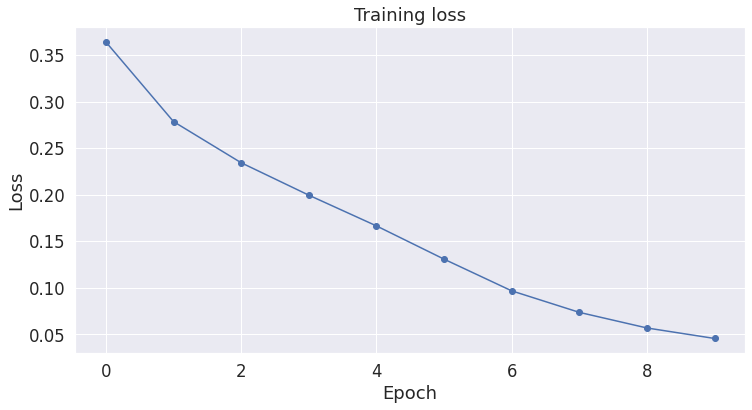

In [ ]:
def select_model(type_of_model,path,weights=None,label_list=None):
    if(type_of_model=='weighted'):
        model = SC_weighted_BERT.from_pretrained(
        path, # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 2, # The number of output labels--2 for binary classification             # You can increase this for multi-class tasks.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
        weights=weights
    )
    else:
        print("Error in model name!!!!")
    return model

class_weights = [sum(y_tn)/len(y_tn), 1 -sum(y_tn)/len(y_tn)]

print(class_weights)

torch.cuda.empty_cache()

model = select_model(veParams['what_bert'], veParams['path_files'], class_weights)

import numpy as np
def getProb(temp):
    t = np.exp(temp)
    return t[1]/(sum(t))

model.cuda()
bestValAcc  = 0
bestValMF1  = 0
besttest_df  = None
bestEpochs = -1

# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

epochs = veParams['epochs']
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
loss_values = []

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader) 

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
 
    # Evaluate data for one epoch
    origValValue = []
    preValValue  = []
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
      
        origValValue.extend(label_ids)
        valPred_flat = np.argmax(logits, axis=1).flatten()
        preValValue.extend(valPred_flat)
        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    valMf1Score = f1_score(origValValue, preValValue, average='macro')
#    if ((eval_accuracy/nb_eval_steps) > bestValAcc):
    if (valMf1Score > bestValMF1):
         bestEpochs = epoch_i
         bestValMF1 = valMf1Score
         bestValAcc  = eval_accuracy/nb_eval_steps
         besttest_df = getPerformanceOfLoader(test_dataloader)
         model.save_pretrained(veParams['outputDir'])
         tokenizer.save_pretrained(veParams['outputDir'])
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")

print(bestEpochs)

import matplotlib.pyplot as plt
#%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

besttest_df.head()

testData['pred']=besttest_df['target']

evalMetric(list(testData['hate']), list(testData['pred']))

testData.to_csv(veParams['outputDir']+"kaEn_test_pred.csv",index=False)

In [4]:
from transformers import AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("/content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed")
modelLoaded = AutoModelForSequenceClassification.from_pretrained("/content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed")

loading file vocab.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading configuration file /content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed/config.json
Model config BertConfig {
  "_name_or_path": "/content/gdrive/MyDrive/Final Project/Code/TFNLP/IndicLang/Kannada/Code-Mixed",
  "architectures": [
    "SC_weighted_BERT"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform"

In [5]:
import pandas as pd
testData =  pd.read_csv("/content/gdrive/MyDrive/Final Project/Code/Dataset/Bengali hate speech test.csv")
# testData
# features: X
# ground truth: y 
X_ts, y_ts = list(testData['sentence']), list(testData['hate'])


In [6]:
X_ts

['পাপন শালা রে রিমান্ডে নেওয়া দরকার',
 'বাল ছাল তর সাউয়া😡',
 'ইয়েছির আলী হালা খেলা জানেনা',
 'এগোলি ছাগল',
 'এ আগেই তো জানতো তারমানে পিকসিং করছে পাপন মাদার সুদ',
 'বাল জানেন',
 'সালা গাজা খুর',
 'সব কারশাজি হচ্ছে পাপন মাদারছোদের',
 'এই চুদির ভাই তুই কোথায় শুনলি সাকিব ইংল্যান্ডেের হয়ে খেলবে??ক্যাপশনতো দিয়ে বসলি।',
 'খানকির পো তো বাট বাট চোদাস ক্যন বসি বাট বাট করলে তোর পাছায় দিমু পেপে গাচের ডাট',
 'একেই বলে কুত্তা ভাগ্য কাইশ্যার মতে টা ম্যাচেই সেঞ্চুরি করতে পারল না',
 'মুসফিক বাল কামাইছে',
 'মুসফিক গরুর মতো চিল্লাইলো 😁',
 'এই পৃথিবীতে কে এত ভালো মানুষ আছে যারা মধ্যে মেয়ে মানুষের চাওয়া নেই যত সব ফালতু খবর মানুষ জনের খেদে দেএ কাজ নেই মানুষের বেকেতি বেপার নিয়ে এদের মাথা ব্যাথা',
 'মাদার চোদরা একটাও ভালো না',
 'মাগীরা বিয়ে করে পাবে একটা বিয়ে ছাড়া পাবে অনেক নিত্য নতুন এক ঢিলে দু পাখি। বিয়ে ছাড়া যদি আর্থিক আর দৈহিক দুটোই ছাড়ানো যায় তাহলে বিয়ের দরকার কি?',
 'তর মতো বাইন্চোদরা বাংলাদেশ কে নষ্ট করছে কই বললিনা কখন সে খেলবে ইংলেন্ডের হয়ে',
 'শয়তানের বাচ্চা রে জুতা দিয়া পিট',
 'আরে এদের মত পেলেয়ার 

In [7]:
# y_ts

In [8]:
import pandas as pd
def Diff(a,b):
    return list(set(a) -set(b))

def re_sub(pattern, repl,text):
    return re.sub(pattern, repl, text)


def preprocess_sent(sent):
    sent = re.sub(r"http\S+", " ", sent.lower())
    sent = re.sub(r"@\S+", "@user", sent)

    #print(sent)
    sent = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "",sent)
    sent = emoji.demojize(sent)
    sent = re_sub(r"[:\*]", " ",sent)
    sent = re.sub(r"[<\*>]", " ",sent)
    sent = sent.replace("&amp;", " ")
    sent = sent.replace("ðŸ¤§", " ")
    sent = sent.replace("\n", " ")
    sent = sent.replace("ðŸ˜¡", " ")
    return sent

def create_attention_masks(input_ids):
    attention_masks = []
    for seq in tqdm(input_ids):
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return np.array(attention_masks)

def getFeaturesandLabelTest(X):
    sentences = list(X)
    sentences = ["[CLS] "+ preprocess_sent(i) + " [SEP]"for i in sentences]
    tokenizer_texts = list(map(lambda t: tokenizer.tokenize(t, truncation=True, max_length=128)[:512], tqdm(sentences)))
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(tokenizer_texts)]
    input_ids = pad_sequences(sequences = input_ids, maxlen = veParams['max_length'], dtype = 'long', padding='post', truncating='post')
    attention_masks_data = create_attention_masks(input_ids)
    X_data = torch.tensor(input_ids)
    attention_masks_data = torch.tensor(attention_masks_data)
    return X_data, attention_masks_data

veParams={
    'max_length':128,
    'path_files': 'bert-base-multilingual-uncased',
	#'path_files': 'google/muril-base-cased',
    'what_bert':'weighted',
    'batch_size':16,
    'is_train':True,
    'learning_rate':2e-5,
    'epsilon':1e-8,
    'random_seed':30,
    'epochs':10,
    'to_save':True,
    'frac':0.8,
    'outputDir':'/content/gdrive/MyDrive/IndicLang/Kannada/Code-Mixed/'
    # /content/drive/MyDrive/IndicLang/Kannada/Code-Mixed
}

In [9]:
def hateSpeechAnalysis(X_in):
    X_test, attention_masks_test = getFeaturesandLabelTest(X_in)
    # X_test
    # #Dataset wrapping tensors.
    test_data = TensorDataset(X_test, attention_masks_test)
    test_data
    # #Samples elements randomly. If without replacement(default), then sample from a shuffled dataset.
    test_sampler = SequentialSampler(test_data)

    # #represents a Python iterable over a dataset
    test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = veParams['batch_size'])
    testOutputs = testPerformanceOfLoader(test_dataloader)
    return testOutputs
# test_dataloader

In [10]:
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

def testPerformanceOfLoader(test_dataloader):
    # model.eval()
    # Tracking variables 
    predictions , true_labels = [], []
    # Predict 
    for batch in test_dataloader:
    #print(batch)
    # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
  
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask = batch
  
        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = modelLoaded(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        # label_ids = b_labels.to('cpu').numpy()
        # Store predictions and true labels
        pred_flat = np.argmax(logits, axis=1).flatten()
        predictions.extend(pred_flat)
        # true_labels.extend(label_ids)

    df = pd.DataFrame()
    # df['id']=testData['sentence']
    # df['target'] = predictions

    return predictions

No GPU available, using the CPU instead.


In [11]:
X_in = ['সালা হারামি একটা']
y_out = hateSpeechAnalysis(X_ts)
# int(y_out[0])
# if int(y_out[0]) == 0 :
#   print("It is not a hate speech")
# else:
#   print("It is a hate speech")
# if 
# output = int(y_out[0])
# output

100%|██████████| 4498/4498 [00:00<00:00, 15072.96it/s]


In [12]:
predictions= np.array(y_out)
predictions

array([1, 1, 1, ..., 0, 0, 0])

In [13]:
print(classification_report(y_ts, predictions, target_names = ['NH (Class 0)','Hate (Class 1)']))

                precision    recall  f1-score   support

  NH (Class 0)       0.98      0.97      0.97      2950
Hate (Class 1)       0.95      0.95      0.95      1548

      accuracy                           0.97      4498
     macro avg       0.96      0.96      0.96      4498
  weighted avg       0.97      0.97      0.97      4498



#### Confusion Matrix

In [14]:
cf_matrix = confusion_matrix(y_ts,predictions)

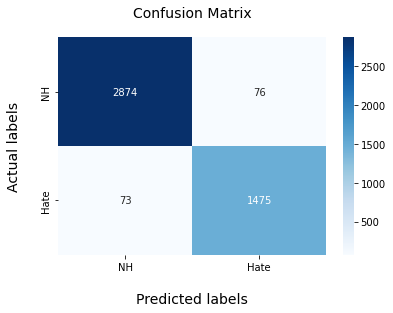

In [17]:
ax = sns.heatmap(cf_matrix, annot=True, fmt='d',cmap='Blues' )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted labels", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['NH', 'Hate'])

# set y-axis label and ticks
ax.set_ylabel("Actual labels", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['NH', 'Hate'])

# set plot title
ax.set_title("Confusion Matrix", fontsize=14, pad=20)

plt.show()

#### ROC AUC

In [18]:
auc = roc_auc_score(y_ts,predictions)
auc

0.9635398326982876

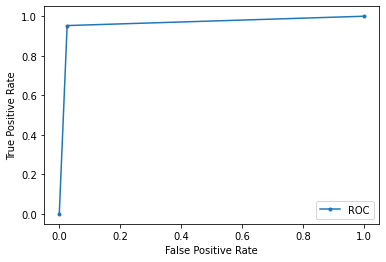

In [19]:
# calculate roc curves
# ns_fpr, ns_tpr, _ = roc_curve(test_lbls,predictions)
fpr, tpr, _ = roc_curve(y_ts,predictions)
# plot the roc curve for the model
# plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='ROC')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()